<a href="https://colab.research.google.com/github/lgvaz/mantisshrimp/blob/master/tutorials/mantisshrimp_models/1.faster_rcnn_quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction Guide

## Prerequisites

### Local machine

Be sure you already installed all the dependencies by following the instructions [here](https://lgvaz.github.io/mantisshrimp/readme_link.html#manual-install).

In this tutorial we make the use of two optional dependencies: `fastai2` and `pytorch-lightning`, for training the model it's required that you install at least one of them.

For transforming our data, we're going to use the [albumentations](https://github.com/albumentations-team/albumentations) library.

All can be installed by running the following on your terminal:

```bash
pip install fastai2
pip install pytorch-lightning
pip install albumentations
```

### Colab

First, enable the GPU runtime:  
`Runtime` -> `Change runtime type` -> `Hardware accelerator dropdown` -> `GPU`  

Install the required dependencies by running the following piece of code:

In [ ]:
!pip install pytorch-lightning
!pip install fastai2
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install albumentations --upgrade
!pip install git+git://github.com/lgvaz/mantisshrimp.git

## Imports

Let's start by importing everything that we need:

In [ ]:
from mantisshrimp.imports import *
from mantisshrimp import *
import albumentations as A


Mantisshrimp makes use of wildcard imports (the `*` imports) so you can easily get everything you need.

The line `from mantisshrimp.imports import *` will import commonly used packages like `np` and `plt`.

The line `from mantisshrimp import *` will import all mantisshrimp modules needed for development.

<div class="alert alert-info">
    
**Note for advanced pythonistas:**

If you're an experienced pythonista you might be worried about using wildcard imports, they're generally considered dangerous and bad practice.

But fear not! When developing the library we make extra sure that no name conflict happens, so everything is safe.

</div>

## Dataset

For this tutorial we're going to use the [pets](https://www.robots.ox.ac.uk/~vgg/data/pets/) dataset, what a better way to start than with dogs and cats am I right?

Mantisshrimp has a community maintaned module that **automatically** downloads the dataset for you. Not surprisingly, it's called `datasets`.  

### Load

The following will download the dataset (or used a cached version if you already downloaded) and return the path to it:

In [ ]:
data_dir = datasets.pets.load()

We can see where the dataset is downloaded by printing the contents of `data_dir`:

In [ ]:
print(data_dir)

/root/.mantisshrimp/data/pets


A new directory called `.mantisshrimp` will be created in your home directory, anything mantisshrimp needs to cache will be stored there.

### Parser

The `Parser` is one of the most important concepts of mantisshrimp, it's what allow us to work with **any** annotation format.

The basic idea of a parser is to convert any custom format to something the library can understand. We provide a wide variety of parsers via the `datasets` modules (each dataset will come with it's own parser), but you might still need to create a custom parser for your custom dataset. Fear not! Creating parsers is very easy, after you're finished with this tutorial, check [this](https://lgvaz.github.io/mantisshrimp/tutorials/mantisshrimp_data/intro_parser.html) one to understand how to do so.

As I previously said, each dataset will come with it's own custom parser, so let's grab the one for pets!

In [ ]:
parser = datasets.pets.parser(data_dir)

The `datasets` interface will always have **at least** two functions: `load` and `parser`.

`parser` will always receive **at least** one argument, the path to the directory holding the data.

Additional parameters might be avaiable for the dataset your using, be sure to check the function documentation.

For pets, we have the optional parameter `mask` when calling `parser` that defaults to `False`, enabling this option will also return segmentation masks for our images (and in that case, we could train a `MaskRCNN`).

Other custom functions might be available for your dataset (like visualization functions), check everything that is avaialable by reading the dataset documentation (work in progress) or by using the power of autocompletion (type `datasets.pets.` and see what your editor suggests).

If your editor does not support autocompletion, you can use this little trick:

In [ ]:
dir(datasets.pets)

Next step is to define the `train/valid` splits for the data, let's use random splits for this one:


In [ ]:
data_splitter = RandomSplitter([.8, .2])

And to actually parse the data, we call the `parse` method passing the `data_splitter`.

This will loop through all the data and will return two lists of records, one for each split defined in `RandomSplitter`.

In [ ]:
train_records, valid_records = parser.parse(data_splitter)

<div class="alert alert-info">
    
**Note:**

If you instead defined 3 splits in `RandomSplitter`, calling `parse` would return 3 lists of records.
  

</div>

<div class="alert alert-warning">

**Important**

A record is a dictonary that contains all parsed fields defined by the parser used. No matter what format the annotations were in, a record will always have a common structure, thanks to this, all library functions/models will always work on your data.

</div>

### Visualize

We can visualize a record with `show_record`, it will display the image and any annotations it has.

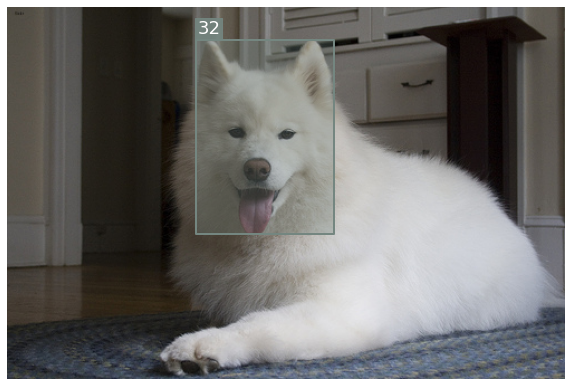

In [ ]:
show_record(train_records[0])

You might want to visualize multiple records at once instead of just one, mantisshrimp has a way of transforming **any** `show` function (even your custom ones) that works on a single item into a function that display multiple items.

The first step, is to create a list of records:

In [ ]:
records = [train_records[i] for i in range(6)]

Then, for each record, you take the original show function (in this case, `show_record`) and wrap it with `partial`, passing the same arguemnts as before.

In [ ]:
show_record_partials = [partial(show_record, record=record) for record in records]

Now, the only thing left is to call `plot_grid`, passing the list of wrapped `show_record` and the number of columns we want our grid to have. Since we have 6 records, let's use 3 columns (and automatically 2 rows).

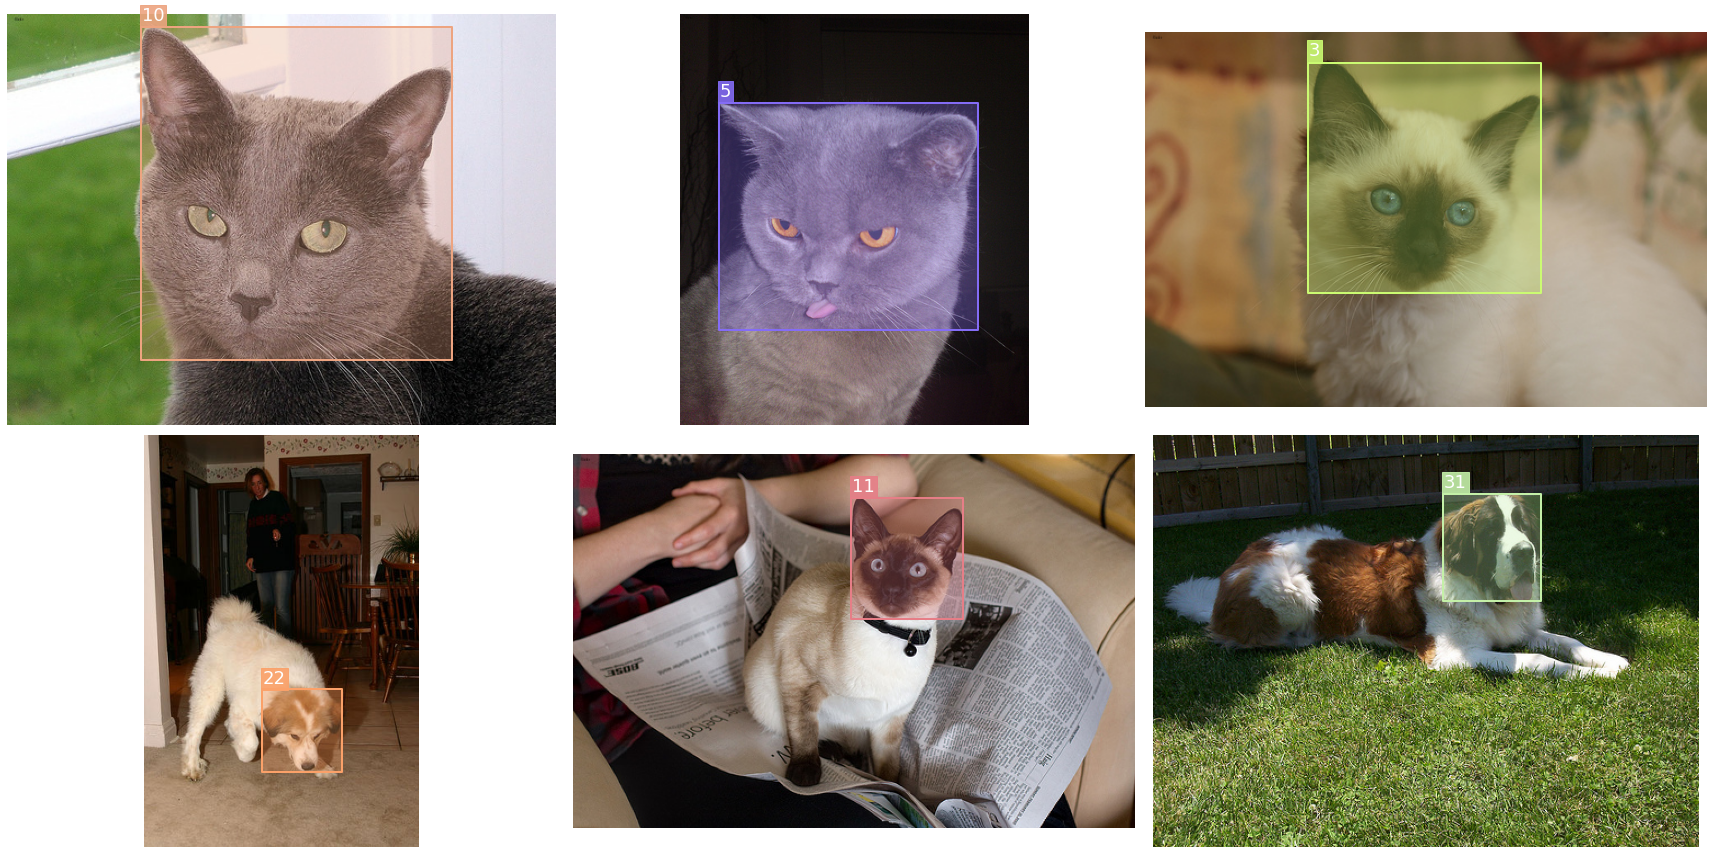

In [ ]:
plot_grid(show_record_partials, ncols=3)

<div class="alert alert-info">

**Why not show_records?:**  

You might be tempted to ask: "Why not just have a `show_records` function instead of this `partial` and `plot_grid` stuff?". 

That's a very valid question! But a `show_records` function is limited to only that, showing records. At some point you will need to write a custom visualization function. We believe that providing the tools to help you write that function heavily outweights the easability of `show_records`. 

As I said before, you can transform **any** function that shows a single image into a function that shows any number of images in a grid view.The only requirement to functions you pass to `plot_grid` is that they should take a `plt.Axes` as an argument (named `ax`), and you use this `ax` to plot. Take a look at the source code of `show_img` for a very simple example.

</div>

### Additional functions

The person who implemented support for the pets dataset also included a function for visualizing the height/width distribution of the images, let's take a look at that:

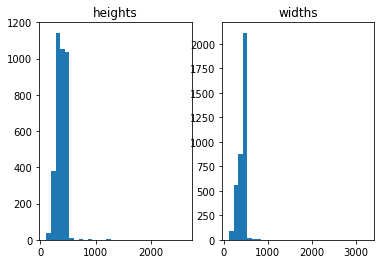

In [ ]:
all_records = train_records + valid_records
_ = datasets.pets.plot_size_histogram(all_records)

It's a bit hard to see because of the outliers, but it seems majority of images are about 400 pixels in size, we can use this information when defining the transforms in the next step.

## Transforms

Transforms is an essential stage of any training pipeline, you can find a multitude of different transforms libraries online: [albumentations](https://github.com/albumentations-team/albumentations), [solt](https://github.com/MIPT-Oulu/solt), [torchvision](https://pytorch.org/docs/stable/torchvision/transforms.html#transforms-on-pil-image), only to cite a few.

With mantisshrimp you can use any transforms library, you just need to inherit and override all abstract methods of the `Transform` class.

For simplicity, we currently provide out of the box support for the widely used [albumentations](https://github.com/albumentations-team/albumentations) library, and we plan to add more.

Let's define a list of transforms to be applied to the train and valid data. For validation we only use deterministic transforms like resizing and normalizing, but for training, we also define augmentation (random) transforms like rotating the image by a random ammount, this means that each time we use these transforms we are going to get different results.

In [ ]:
imagenet_mean, imagenet_std = imagenet_stats

valid_tfms = AlbuTransform(
    [
        A.LongestMaxSize(384),
        A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]
)

train_tfms = AlbuTransform(
    [
        A.LongestMaxSize(384),
        A.RandomSizedBBoxSafeCrop(320, 320, p=0.3),
        A.HorizontalFlip(),
        A.ShiftScaleRotate(rotate_limit=20),
        A.RGBShift(always_apply=True),
        A.RandomBrightnessContrast(),
        A.Blur(blur_limit=(1, 3)),
        A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ]
)

<div class="alert alert-warning">

**Important:**

The order of the transforms in the list matter!

</div>

## Dataset

Not to be confused with our previous `datasets` module, `Dataset` is a class that combines the records and transforms.

For creating a `Dataset` we just need need to pass the parsed records from the previous step and optionally the transforms.


In [ ]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

Let me explain a bit more what a `Dataset` really does:  
* Prepares the record: For example, in the record we just have a filename that points to the image, it's at this stage that we open the image (same for masks). It's really simple, take a look at the source `mantisshrimp/data/prepare_record.py`
* Apply the transforms to the already prepared record

What is really important is that this operations are applied **lazily**, meaning they are only applied when you index the dataset to get an item.

This means that, if you have augmentation (random) transforms, each time you get the **same** item from the dataset you'll get slightly different version of it!

Let's visualize it ourselves combining `show_sample` with `plot_grid`:

<div class="alert alert-warning">

**Important:**

Because we normalized our images with `imagenet_stats` we now have to denormalize it when showing.

The `show_sample` function receives an optional argument called `denormalize_fn` that we can pass `denormalize_imagenet`.

</div>

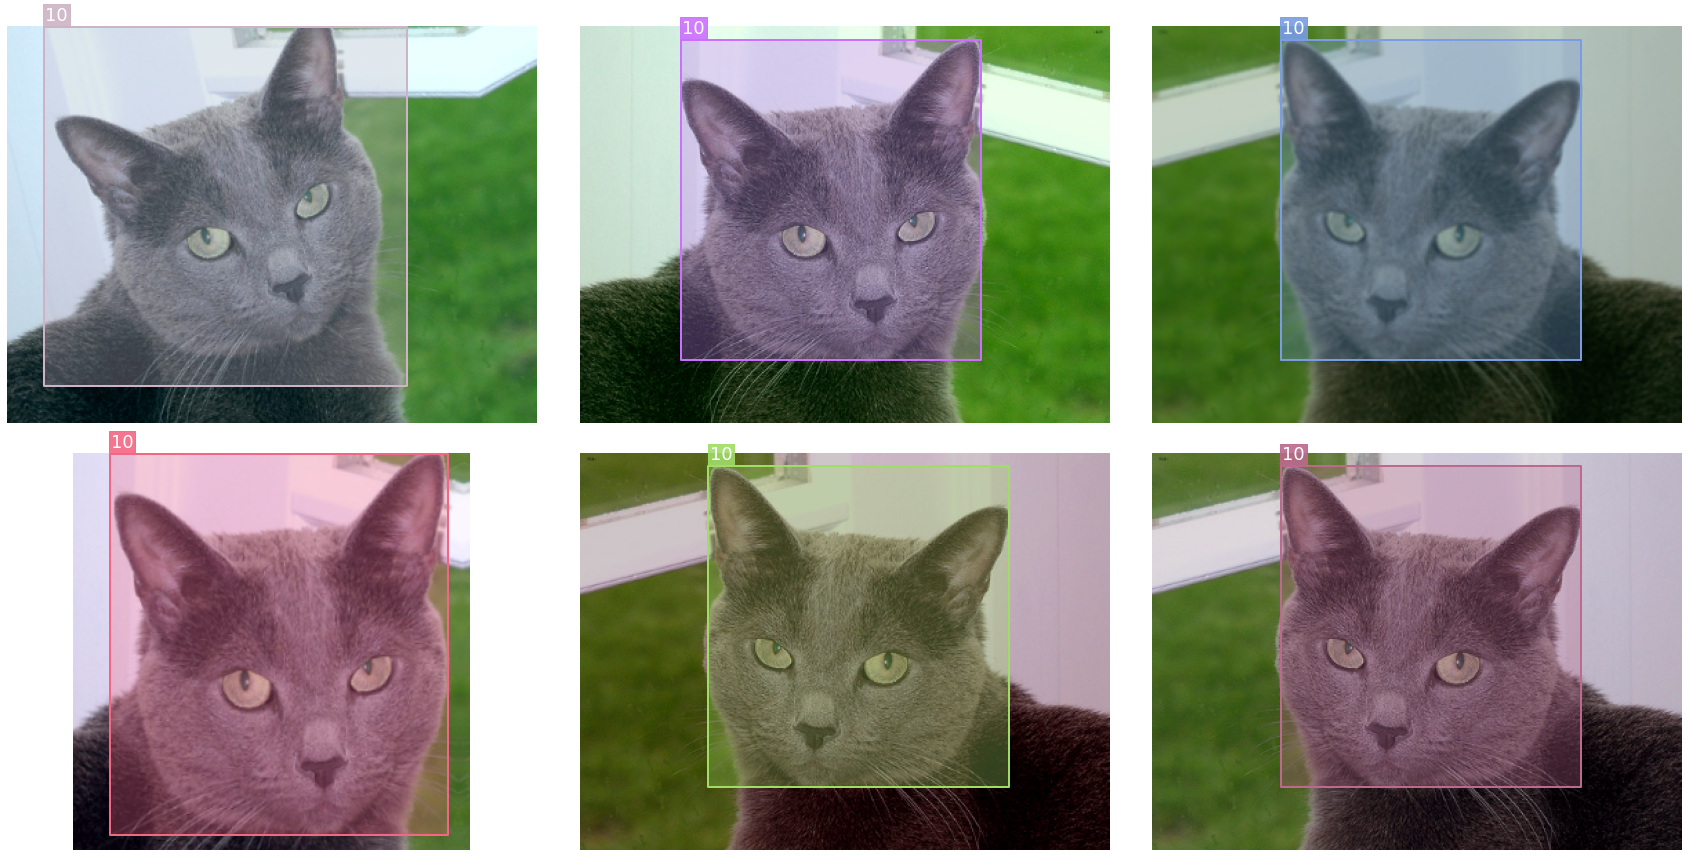

In [ ]:
samples = [train_ds[0] for _ in range(6)]
show_sample_partials = [partial(show_sample, sample=sample, denormalize_fn=denormalize_imagenet)
                        for sample in samples]
plot_grid(show_sample_partials, ncols=3)

<div class="alert alert-info">

**Experiment:**. 

Try training you model without any augmentation transforms, how much worse are the results?

</div>

## Model

This task only requires us to predict bounding boxes, so we can use `FasterRCNN`, the only required argument we need to pass to the model is the number of classes our dataset has (which is simply the length of `datasets.pets.CATEGORIES`) + 1 for the background.

In [ ]:
model = MantisFasterRCNN(num_classes=len(datasets.pets.CATEGORIES) + 1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


## DataLoader

Each model has its own dataloader, these still are the pytorch `DataLoader`s with all know, but with possible modifications. For example, the dataloaders for the RCNN models have a custom collate function.

To get a dataloader for a specific model you just need to do `ModelClass.dataloader` and pass the same arguments you would pass to a normal pytorch `DataLoader`. You can call the method `dataloader` directly on the class or on the instatiated model.

In [ ]:
train_dl = model.dataloader(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = model.dataloader(valid_ds, batch_size=16, num_workers=4, shuffle=False)

<div class="alert alert-warning">

**Important:**

We are currently working on a better interface for the model and dataloader, so this might slighthy change in the following weeks.

</div>

## Metrics

Coming soon! We're working on integrating the `pycocotools` AP metric, stay tuned!

## Training

Mantisshrimp is agnostic to the training engine, so you can use your favorite library for training the model.  

We currently support [fastai2](https://github.com/fastai/fastai2) and [pytorch-lightning](https://github.com/PyTorchLightning/pytorch-lightning) out of the box, meaning that we have helper functions to ease out the connection. But this does not mean you cannot use other libraries, it just means you might have to write some more code.

### fastai

For getting access to the helper functions to train with fastai, just `import` as follows:

In [ ]:
from mantisshrimp.engines.fastai import *

<div class="alert alert-info">

**Note:**  

When you import the fastai engine as above we internally do: `from fastai2.vision.all import *` (fastai users might be familiar with this).

Then we put all the imports into a namespace called `fastai`, so all the functions normally imported by fastai are accessible via `fastai.<name>`, e.g. `fastai.DataBlock`.

</div>

Just create a `Learner` like you would do in `fastai` and train your model!  

In [ ]:
learn = rcnn_learner(dls=[train_dl, valid_dl], model=model)

In [ ]:
learn.fine_tune(10, lr=1e-4)

### pytorch-lightning

Same as we did with fastai, for getting access to the helper functions to train with lightning execute the imports:

In [ ]:
from mantisshrimp.engines.lightning import *

Inherit from `RCNNLightningAdapter` and implement the method `configure_optimizers`.  

In [ ]:
class LightModel(RCNNLightningAdapter):
    def configure_optimizers(self):
        opt = SGD(self.parameters(), 2e-4, momentum=0.9)
        return opt

<div class="alert alert-info">
    
**Note:**
    
If you are used with lightning, you may be wondering what happened with `training_step`, `validation_step` and methods that we normally have to override while using lightning. What happens is that under the hood `RCNNLightningAdapter` is already implement those methods for you (with the additional bennefit of supporting `Metric`s.  

If you need more custom functionality, don't be afraid of reimplementing those methods, there is no magic happening under the hood, all lightning!  
    
</div>

Now, just creat your lightning model by to it the model we created before and the metric you want to use.

In [ ]:
light_model = LightModel(model, metrics=metrics)

In [ ]:
trainer = Trainer(max_epochs=3, gpus=1)
trainer.fit(light_model, train_dataloader, valid_dataloader)

## Inference

### Load a model

I trained the model with `fastai` running `fine_tune` twice and I got the following results:  
* train_loss: 0.06772  
* valid_loss: 0.074435  

If you don't want to wait for your model to train, I made the weights publicy available so we can download them with `torch.hub`:

In [ ]:
weights_url = "https://mantisshrimp-models.s3.us-east-2.amazonaws.com/weights-384px-adam2%2B%2B.pth.zip"
state_dict = torch.hub.load_state_dict_from_url(weights_url, map_location=torch.device("cpu"))

<div class="alert alert-info">

**Note:**  

Typically inference is done on the cpu, this is why we specify the paramater `map_location` to `cpu` when loading the state dict.

</div>

Let's recreate the model and load the downloaded weights:

In [ ]:
model = MantisFasterRCNN(num_classes=len(datasets.pets.CATEGORIES) + 1)
model.load_state_dict(state_dict)

The first step for prediction is to have some images, let's grab some random ones from the validation dataset:

### Predict all at once

In [ ]:
samples = random.choices(valid_ds, k=6)
images = [sample["img"] for sample in samples]

Every model has a `predict` method, the first argument should always be the a list of images, the other parameters might vary a bit and are specific to the model you're using. For `FasterRCNN` we have `detection_threshold`, which specifies how confident the model should be to output a bounding box.

In [ ]:
preds = model.predict(images, detection_threshold=.8)


For showing a single prediction we can use `show_pred`, and if you want to plot a grid of images... You already know! `partial` and `plot_grid`!

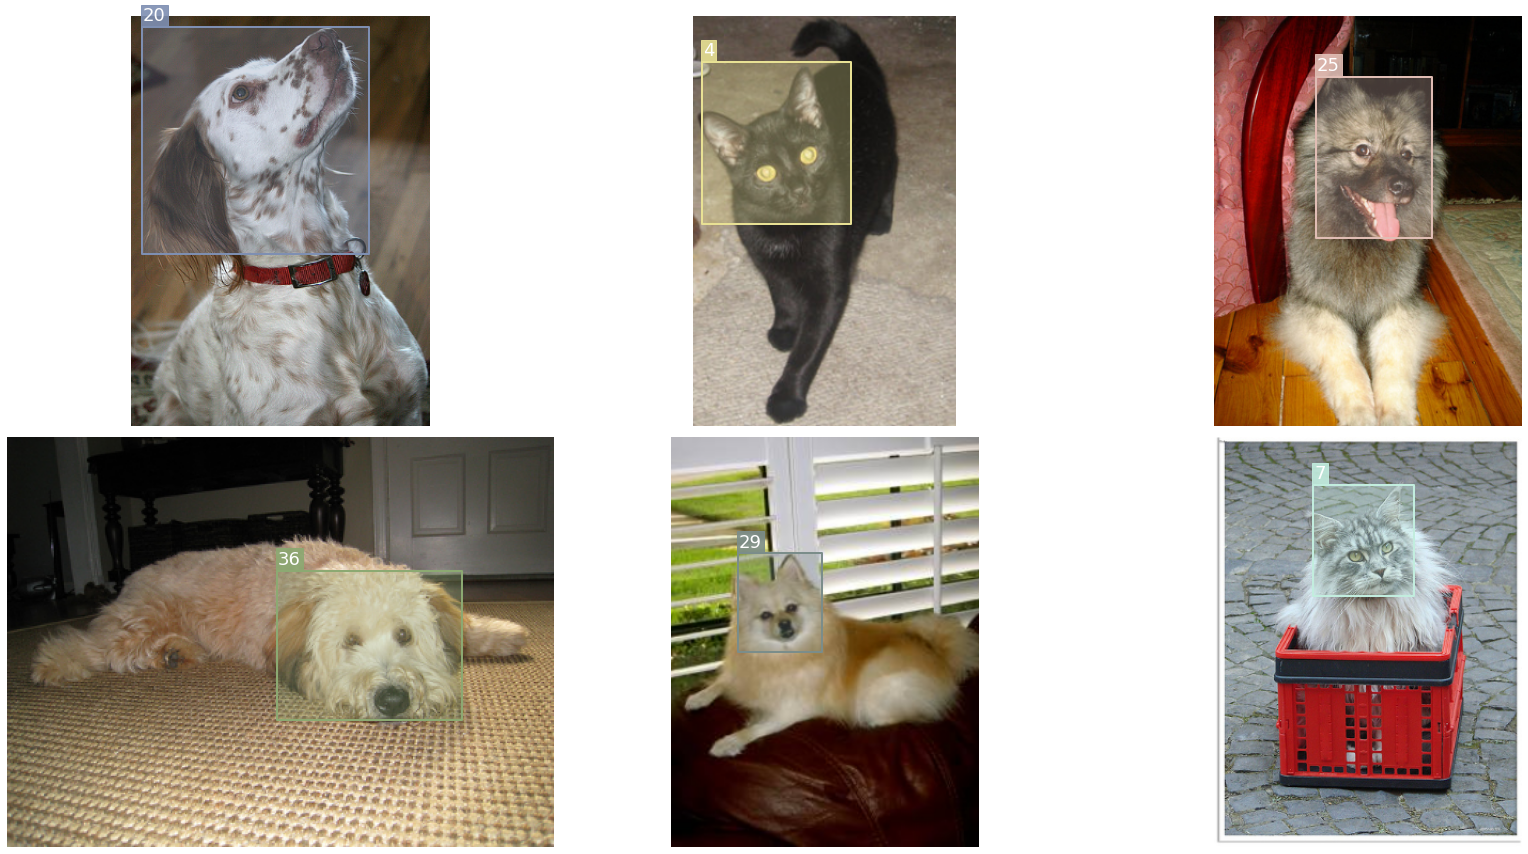

In [ ]:
show_pred_partials = [partial(show_pred, img=img, pred=pred, denormalize_fn=denormalize_imagenet)
                      for img, pred in zip(images, preds)]
plot_grid(show_pred_partials, ncols=3)

<div class="alert alert-info">

**Note:**

Try changing the value of `detection_threshold` and observe how the results change.

</div>

### Predict in chunks

Sometimes you just have too many images to predict everything at once, in this scenario you have to split your data and predict in smaller batches. How to achieve this is very specific to your application and it's up to you, but you still will want to use `model.predict` as it is the base for any approach.

Let's imagine we need to predict all images we have on our validation set, this is how a approach with a `DataLoader` would look like:

In [ ]:
dl = DataLoader(valid_ds, batch_size=8, collate_fn=lambda o: o)

<div class="alert alert-warning">

**Important:**

The default `DataLoader` tries to collate (combine the items) of the batch in a very specific way, specifying `collate_fn=lambda o: o` is saying "whatever you receive as a batch, return it without modifications".

</div>

Then, just write iterate over the dataloader and predict on each batch just like we done before:

In [ ]:
all_preds = []
for batch in dl:
    images = [sample["img"] for sample in batch]

    preds = model.predict(images, detection_threshold=.8)
    all_preds.append(preds)

<div class="alert alert-info">

**Note:**

Keep in mind the above is running on cpu, so it's going to take a reallyyy long time!

</div>